# TP 5 : machine learning using neural network for text data

In this practical session, we are going to build simple neural models able to classify reviews as positive or negative. The dataset used comes from AlloCine.
The goals are to understand how to use pretrained embeddings, and to correctly tune a neural model.

you need to load:
- Allocine: Train, dev and test sets
- Embeddings: cc.fr.300.10000.vec (10,000 first lines of the original file)

## Part 1- Pre-trained word embeddings
Define a neural network that takes as input pre-trained word embeddings (here FastText embeddings). Words are represented by real-valued vectors from FastText. A review is represented by a vector that is the average or the sum of the word vectors.

So instead of having an input vector of size 5000, we now have an input vector of size e.g. 300, that represents the ‘average’, combined meaning of all the words in the document taken together.

## Part 2- Tuning report
Tune the model built on pre-trained word embeddings by testing several values for the different hyper-parameters, and by testing the addition on an hidden layer.

Describe the performance obtained by reporting the scores for each setting on the development set, printing the loss function against the hyper-parameter values, and reporting the score of the best model on the test set.

-------------------------------------

## Useful imports

Here we also:
* Look at the availability of a GPU. Reminder: in Collab, you have to go to Edit/Notebook settings to set the use of a GPU
* Setting a seed, for reproducibility: https://pytorch.org/docs/stable/notes/randomness.html


In [ ]:
!pip install -q torchtext==0.14.1 torchdata==0.5.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cu121 requires torch==2.5.1, but you have torch 1.13.1 which is incompatible.
torchvision 0.20.1+cu121 requires torch==2.5.1, but you have torch 1.13.1 which is incompatible.


In [ ]:
import time
import pandas as pd
import numpy as np
# torch and torch modules to deal with text data
import torch
import torch.nn as nn
import torchtext
from torchtext.data import get_tokenizer
#from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
# you can use scikit to print scores
from sklearn.metrics import classification_report

# For reproducibility, set a seed
torch.manual_seed(0)

# Check for GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Paths to data:

In [ ]:
# Data files
train_file = "allocine_train.tsv"
dev_file = "allocine_dev.tsv"
test_file = "allocine_test.tsv"
# embeddings
embed_file='cc.fr.300.10000.vec'

## 1- Read and load the data


### 1.1- The class Dataset (code given)

Reminder from TP1, the simplest solution is to use the DataLoader from PyTorch:

* the doc here https://pytorch.org/docs/stable/data.html and here https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
* an example of use, with numpy array: https://www.kaggle.com/arunmohan003/sentiment-analysis-using-lstm-pytorch

Here, we are going to define our own Dataset class instead of using numpy arrays. It allows for a finer definition of the behavior of our dataset, and it's easy to reuse.

* Dataset is an abstract class in PyTorch, meaning it can't be used as is, it has to be redefined using inheritance https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
* you must at least overwrite the __getitem__() method, supporting fetching a data sample for a given key.
* in practice, you also overwrite the __init__() to explain how to initialize the dataset, and the __len__ to return the right size for the dataset

You can also find many datasets for text ready to load in pytorch on: https://pytorch.org/text/stable/datasets.html

#### Read and load data (code given)

Read the code below that allows to load the data, note that:
- we tokenize the text (here a simple tokenization based on spaces)
- we build the vocabulary corresponding to the training data:
  - the vocabulary corresponds to the set of unique tokens
  - only tokens in the training data are known by the system
  - the vocabulary here is a Torch specific object, more details in section 0.4 below

▶▶ **Question:** why do we use only tokens in the training set to build the vocabulary? What do we do with the dev and test sets?

In [ ]:
# Here we create a custom Dataset class that inherits from the Dataset class in PyTorch
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__


class Dataset(torch.utils.data.Dataset):

    def __init__(self, tsv_file, vocab=None ):
      """ (REQUIRED) Here we save the location of our input file,
        load the data, i.e. retrieve the list of texts and associated labels,
        build the vocabulary if none is given,
        and define the pipelines used to prepare the data """
      self.tsv_file = tsv_file
      self.data, self.label_list = self.load_data( )
      # splits the string sentence by space, can t make the fr tokenzer work
      self.tokenizer = get_tokenizer( None )
      self.vocab = vocab
      if not vocab:
        self.build_vocab()
      # pipelines for text and label
      self.text_pipeline = lambda x: self.vocab(self.tokenizer(x)) #return a list of indices from a text
      self.label_pipeline = lambda x: int(x) #simple mapping to self

    def load_data( self ):
      """ Read a tsv file and return the list of texts and associated labels"""
      data = pd.read_csv( self.tsv_file, header=0, delimiter="\t", quoting=3)
      instances = []
      label_list = []
      for i in data.index:
        label_list.append( data["sentiment"][i] )
        instances.append( data["review"][i] )
      return instances, label_list

    def build_vocab(self):
      """ Build the vocabulary, i.e. retrieve the list of unique tokens
      appearing in the corpus (= training set). Se also add a specific index
      corresponding to unknown words.  """
      self.vocab = build_vocab_from_iterator(self.yield_tokens(), specials=["<unk>"])
      self.vocab.set_default_index(self.vocab["<unk>"])

    def yield_tokens(self):
      """ Iterator on tokens """
      for text in self.data:
        yield self.tokenizer(text)

    def __len__(self):
      """ (REQUIRED) Return the len of the data,
      i.e. the total number of instances """
      return len(self.data)

    def __getitem__(self, index):
      """ (REQUIRED) Return a specific instance in a format that can be
      processed by Pytorch, i.e. torch tensors """
      return (
            tuple( [torch.tensor(self.text_pipeline( self.data[index] ), dtype=torch.int64),
                    torch.tensor( self.label_pipeline( self.label_list[index] ), dtype=torch.int64) ] )
        )

### 1.2- Generate data batches and iterator (code given)

Then, we use *torch.utils.data.DataLoader* with a Dataset object as built by the code above. DataLoader has an argument to set the size of the batches, but since we have variable-size input sequences, we need to specify how to build the batches. This is done by redefining the function *collate_fn* used by *DataLoader*.

```
dataloader = DataLoader(dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)
```

Below:
* the text entries in the original data batch input are packed into a list and concatenated as a single tensor.
* the offset is a tensor of delimiters to represent the beginning index of the individual sequence in the text tensor
* Label is a tensor saving the labels of individual text entries.

The offsets are used to retrieve the individual sequences in each batch (the sequences are concatenated).


In [ ]:
# This function explains how we process data to make batches of instances
# - The list of texts / reviews that is returned is similar to a list of list:
# each element is a batch, ie. a ensemble of BATCH_SIZE texts. But instead of
# creating sublists, PyTorch concatenates all the tensors corresponding to
# each text sequence into one tensor.
# - The list of labels is the list of list of labels for each batch
# - The offsets are used to save the position of each individual instance
# within the big tensor
def collate_fn(batch):
    label_list, text_list, offsets = [], [], [0]
    for ( _text, _label) in batch:
         text_list.append( _text )
         label_list.append( _label )
         offsets.append(_text.size(0))
    label = torch.tensor(label_list, dtype=torch.int64) #tensor of labels for a batch
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0) #tensor of offset indices for a batch
    text_list = torch.cat(text_list) # <--- here we concatenate the reviews in the batch
    return text_list.to(device), label.to(device), offsets.to(device) #move the data to GPU

### 1.3- ▶ Exercise: Load the data

#### ▶ (a) Load the training data
* Use the code above to load the training and dev data with a batch size of 2:
  * First create an instance of the Dataset class
  * Then use this instance to create an instance of the DataLoader class with a batch size of 2, with NO shuffling of the samples, and using the *collate_fn* function defined above. Recall that the DataLoader class has the following parameters:
  ```
  torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=None, collate_fn=None)
  ```

#### ▶ (b) Print first training instances

* Print the first two elements in the Dataset object built on the train set, and the first element in the DataLoader object built on the train. Print also the associated labels. Does it seem coherent?

#### ▶ (c) Shuffling the data

Once you checked that is seems ok, reload the data but this time, shuffle the data during loading.

#### ▶ (d) Load the dev data

Now load the dev data, remembering that you need to give the training vocabulary.

------------------------------------
SOLUTION

In [ ]:
# Load the training and development data
train = Dataset( train_file )
dev = Dataset( dev_file, vocab=train.vocab )

train_loader = DataLoader(train, batch_size=2, shuffle=False, collate_fn=collate_fn) #<-- use shuffle = True instead
dev_loader = DataLoader(dev, batch_size=2, shuffle=False, collate_fn=collate_fn)


print(train[0])
print(train[1])
for input, label, offset in train_loader:
    print( input, label, input.size(), offset )
    break

(tensor([ 2281,  2675,   374,    28, 13940,    15, 11282,    18,  3936,   203,
            1,  7998,     4,   307,  1114,  9134,  4495,     1,    92,  8752,
           24,   104,    28,   117,    53,   638,     8,   418,    23, 23816,
          904,  1378,     1,   126,     8,     1,    86,   108,    46,  4622,
           34,  2719,    91,   203,    49,   121,     2,    49,  1179,   113,
          111,    50,   136,    70,  3190,    19, 11708,     5, 12735,    91,
            7,    47,   431,  1498,   177,     4,  2738,     4,   550,     2,
            4,    46,  7858,    49,  1244,     5,  6791,  1220,     2,     6,
          376,    34,   345,     9,   593,  1158,   233,  2191, 31216, 33258,
         2822,  1486,    23,   219,     1,     3,     7,  2187,   112,    17,
          129, 37130,     1,  2845,    93,    95,  8111]), tensor(0))
(tensor([18487,    54,     7,     5,  8463,   159,  6042,     2, 12809,    12,
           30,  1385,   107,    14,   397,  8726,     1,  4654,     1,

### 1.4- ▶ Exercise: understand the Vocab object

Here the **vocabulary** is a specific object in Pytorch: https://pytorch.org/text/stable/vocab.html

For example, the vocabulary directly converts a list of tokens into integers, see below.

Now try to:
* Retrieve the indices of a specific word, e.g. 'mauvais'
* Retrieve a word from its index, e.g. 368
* You can also directly convert a sentence to a list of indices, using the *text_pipeline* defined in the *Dataset* class, try with:
  * 'Avant cette série, je ne connaissais que Urgence'
  * 'Avant cette gibberish, je ne connaissais que Urgence'
  * what happened when you use a word that is unknown?

Hints: look at these functions
* lookup_indices(tokens: List[str]) → List[int]
* lookup_token(index: int) → str

In [ ]:
train.vocab(['Avant', 'cette', 'série', ','])

[2910, 18, 7, 144]

------------------------------------
SOLUTION

You can use it to retrieve the indice of a specific word, e.g. 'mauvais'.

In [ ]:
print( train.vocab.lookup_indices( ['mauvais'] ))

[246]


In [ ]:
print( train.vocab.lookup_token( 368 ) )

pas,


In [ ]:
train.text_pipeline('Avant cette série, je ne connaissais que Urgence')

[2910, 18, 89, 16, 17, 6120, 8, 10529]

In [ ]:
train.text_pipeline('Avant cette gibberish, je ne connaissais que Urgence')

[2910, 18, 0, 16, 17, 6120, 8, 10529]

## 2- Using pre-trained embeddings (code given)

The first option would be to use randomly initialized word embeddings.
It allows the use of dense, real-valued input, that could be updated during training.
However, we probably don't have enough data to build good representations for our problem during training.
One solution is to use pre-trained word embeddings, built over very big corpora with the aim of building good generic representations of the meaning of words.

Upload the file *cc.fr.300.10000.vec': first 10,000 lines of the FastText embeddings for French, https://fasttext.cc/docs/en/crawl-vectors.html.

* **Each word is associated to a real-valued and low-dimensional vector** (e.g. 300 dimensions). Crucially,  the  neural  network  will  also  learn / update the  embeddings  during  training (if not freezed):  the  embeddings  of  the network are also parameters that are optimized according to the loss function, allowing the model to learn a better representation of the words.

* And **each review is represented by a vector** that should represent all the words it contains. One way to do that is to use **the average of the word vectors** (another typical option is to sum them). Instead of a bag-of-words representation of thousands of dimensions (the size of the vocabulary), we will thus end with an input vector of size e.g. 300, that represents the ‘average’, combined meaning of all the words in the document taken together.

The functions to load the embeddings vectors and build the weight matrix are defined below.

#### 2.1 Load the vectors (code given)

The function below loads the pre-trained embeddings, returning a dictionary mapping a word to its vector, as defined in the fasttext file.

Note that the first line of the file gives the number of unique tokens (in the original file, here we only have 9,999 tokens) and the size of the embeddings.

At the end, we print the vocabulary and the vector for a specific token.

In [ ]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    print("Originally we have: ", n, 'tokens, and vectors of',d, 'dimensions') #here in fact only 10000 words
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = [float(t) for t in tokens[1:]]
    return data

vectors = load_vectors( embed_file )
print( 'Version with', len( vectors), 'tokens')
print(vectors.keys() )
print( vectors['de'] )



Originally we have:  2000000 tokens, and vectors of 300 dimensions
Version with 9999 tokens
dict_keys([',', 'de', '.', '</s>', 'la', 'et', ':', 'à', 'le', '"', 'en', '’', 'les', 'des', ')', '(', 'du', 'est', 'un', "l'", "d'", 'une', 'pour', '/', '|', 'dans', 'sur', 'que', 'par', 'au', 'a', 'l', 'qui', '-', 'd', 'il', 'pas', '!', 'avec', '_', 'plus', "'", 'Le', 'ce', 'ou', 'La', 'ne', 'se', '»', '...', '?', 'vous', 'sont', 'son', '«', 'je', 'Les', 'Il', 'aux', '1', ';', 'mais', "qu'", 'on', "n'", 'comme', '2', 'sa', 'cette', 'y', 'nous', 'été', 'tout', 'fait', 'En', "s'", 'bien', 'ses', 'très', 'ont', 's', 'être', 'votre', 'ai', 'elle', 'n', '3', 'même', "L'", 'deux', 'faire', "c'", 'aussi', '>', 'leur', '%', 'si', 'entre', 'qu', '€', '&', '4', 'sans', 'Je', "j'", 'était', '10', 'autres', 'tous', 'peut', 'France', 'ces', '…', '5', 'lui', 'me', ']', '[', 'où', 'ans', '6', '#', 'après', '+', 'ils', 'dont', 'Pour', '°', '–', 'temps', '*', 'sous', 'Un', 'avoir', 'L', 'A', '}', 'site', 'peu'

### 2.2- Build the weight matrix

We have a list of words associated to vector.
Now we need to specifically retrieve the vectors for the words present in our data, there is no need to keep vectors for all the words.
We thus build a matrix over the dataset associating each word present in the dataset to its vector.
For each word in dataset’s vocabulary, we check if it is in FastText’s vocabulary:
* if yes: load its pre-trained word vector.
* else: we initialize a random vector.

The code below will also examine the coverage, i.e.:
* print the number of tokens from FastText found in the training set
* and the number of unknown words.

In [ ]:
# Load the weight matrix: modify the code below to check the coverage of the
# pre-trained embeddings
emb_dim = 300
matrix_len = len(train.vocab)
weights_matrix = np.zeros((matrix_len, emb_dim))
words_found, words_unk = 0,0

for i in range(0, len(train.vocab)):
    word = train.vocab.lookup_token(i)
    try:
        weights_matrix[i] = vectors[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))
        words_unk += 1
weights_matrix = torch.from_numpy(weights_matrix).to( torch.float32)
print( "Words found:", weights_matrix.size() )
print( "Unk words:", words_unk )

Words found: torch.Size([43072, 300])
Unk words: 37486


## 3- ▶ Exercise: Model definition

#### (a) Define the embedding layer:
Now modify your model to add an embedding layer in the __init__() function below:

* Define *self.embedding_bag*: a layer combining the word embeddings for the words. Here we just give the definition of the layer, i.e.:
  * we use pre initialized weights
  * we want to combine the embeddings by doing the average
See ```nn.EmbeddingBeg.from_pretrained( ..)```, https://pytorch.org/docs/stable/generated/torch.nn.EmbeddingBag.html
* Retrieve the *embedding dimensions* to be used as parameter for the first linear function (look at the *EnbeddingBag* class definition).

#### (b) Use the embedding layer
Now you need to tell the model when to use this embedding layer, thus you need to modify the *forward()* function to say that it needs to first *embed* the input before going through the linear and non linear layers.

Look at the example in the doc: https://pytorch.org/docs/stable/generated/torch.nn.EmbeddingBag.html
Note that this embedding layer needs the information about the offset, to retrieve the sequences / individual documents in the batch.



In [ ]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, hidden_dim, output_dim, weights_matrix):
        # calls the init function of nn.Module.  Dont get confused by syntax,
        # just always do it in an nn.Module
        super(FeedforwardNeuralNetModel, self).__init__()

        # Embedding layer
        #self.embedding_bag = ...

        embed_dim = self.embedding_bag.embedding_dim

        # Linear function
        self.fc1 = nn.Linear(embed_dim, hidden_dim)

        # Non-linearity
        self.sigmoid = nn.Sigmoid()

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, offsets):
        # Embedding layer
        #embedded = ...

        # Linear function
        out = self.fc1(embedded)

        # Non-linearity
        out = self.sigmoid(out)

        # Linear function (readout)
        out = self.fc2(out)
        return out

------------------------------------
SOLUTION

In [ ]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, hidden_dim, output_dim, weights_matrix):
        # calls the init function of nn.Module.  Dont get confused by syntax,
        # just always do it in an nn.Module
        super(FeedforwardNeuralNetModel, self).__init__()

        # Embedding layer
        #  mode (string, optional) – "sum", "mean" or "max". Default=mean.
        self.embedding_bag = nn.EmbeddingBag.from_pretrained(
                              weights_matrix,
                              mode='mean')
        embed_dim = self.embedding_bag.embedding_dim

        # Linear function
        self.fc1 = nn.Linear(embed_dim, hidden_dim)

        # Non-linearity
        self.sigmoid = nn.Sigmoid()

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, offsets):
        # Embedding layer
        embedded = self.embedding_bag(text, offsets)

        # Linear function
        out = self.fc1(embedded)

        # Non-linearity
        out = self.sigmoid(out)

        # Linear function (readout)
        out = self.fc2(out)
        return out

## 4- Train and evaluation (code given)

Look at the code below that performs the training and evaluation of your model.
Note that:
* one epoch is one iteration over the entire training set
* each *input* is here a batch of several documents (here 2)
* the model computes a loss after making a prediction for each input / batch. We accumulate this loss, and compute a score after seing each batch
* at the end of each round / epoch, we print the accumulated loss and accuracy:
  * A good indicator that your model is doing what is supposed to, is the loss: it should decrease during training. At the same time, the accuracy on the training set should increase.
* in the evaluation procedure, we have to compute score for batched of data, that's why we have slight modifications in the code (use of *extend* to have a set of predictions)

Note: here we need to take into account the offsets in the training and evaluation procedures.

In [ ]:
import matplotlib.pyplot as plt
import os

def my_plot(epochs, loss):
    plt.plot(epochs, loss)
    #fig.savefig(os.path.join('./lossGraphs', 'train.jpg'))

def training(model, train_loader, optimizer, num_epochs=5, plot=False ):
  loss_vals = []
  for epoch in range(num_epochs):
    train_loss, total_acc, total_count = 0, 0, 0
    for input, label, offsets in train_loader:
      # Step1. Clearing the accumulated gradients
      optimizer.zero_grad()
      # Step 2. Forward pass to get output/logits
      outputs = model( input, offsets ) # <---- argument offsets en plus
      # Step 3. Compute the loss, gradients, and update the parameters by
      # calling optimizer.step()
      # - Calculate Loss: softmax --> cross entropy loss
      loss = criterion(outputs, label)
      # - Getting gradients w.r.t. parameters
      loss.backward()
      # - Updating parameters
      optimizer.step()
      # Accumulating the loss over time
      train_loss += loss.item()
      total_acc += (outputs.argmax(1) == label).sum().item()
      total_count += label.size(0)
    # Compute accuracy on train set at each epoch
    print('Epoch: {}. Loss: {}. ACC {} '.format(epoch, train_loss/len(train), total_acc/len(train)))
    loss_vals.append(train_loss/len(train))
    total_acc, total_count = 0, 0
    train_loss = 0
  if plot:
    # plotting
    my_plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_vals)


def evaluate( model, dev_loader ):
    predictions = []
    gold = []
    with torch.no_grad():
        for input, label, offsets in dev_loader:
            probs = model(input, offsets) # <---- fct forward with offsets
            # -- to deal with batches
            predictions.extend( torch.argmax(probs, dim=1).cpu().numpy() )
            gold.extend([int(l) for l in label])
    print(classification_report(gold, predictions))
    return gold, predictions

In [ ]:
# Set the values of the hyperparameters
hidden_dim = 4
learning_rate = 0.001
num_epochs = 5
criterion = nn.CrossEntropyLoss()
output_dim = 2

Epoch: 0. Loss: 0.35214536357689546. ACC 0.5004973145016909 
Epoch: 1. Loss: 0.34653718033533154. ACC 0.529739407201114 
Epoch: 2. Loss: 0.33326706543389906. ACC 0.595583847224985 
Epoch: 3. Loss: 0.321205671890749. ACC 0.630992639745375 
Epoch: 4. Loss: 0.3143239427311226. ACC 0.6411378555798687 
              precision    recall  f1-score   support

           0       0.45      0.94      0.61       230
           1       0.82      0.18      0.30       319

    accuracy                           0.50       549
   macro avg       0.64      0.56      0.46       549
weighted avg       0.67      0.50      0.43       549



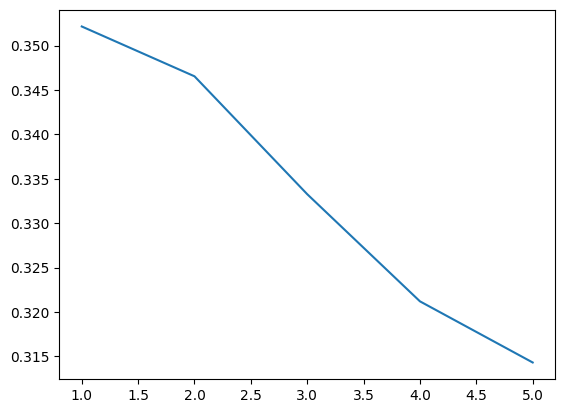

In [ ]:
# Initialize the model
model_ffnn = FeedforwardNeuralNetModel( hidden_dim, output_dim, weights_matrix)
optimizer = torch.optim.SGD(model_ffnn.parameters(), lr=learning_rate)
model_ffnn = model_ffnn.to(device)
# Train the model
training( model_ffnn, train_loader, optimizer, num_epochs=5, plot=True )
# Evaluate on dev
gold, pred = evaluate( model_ffnn, dev_loader )

## 5- ▶ Exercise: Tuning your model

The model comes with a variety of hyper-parameters. To find the best model, we need to test different values for these free parameters.

Be careful:
* you always optimize / fine-tune your model on the **development set**.
* Then you compare the results obtained with the different settings on the dev set to choose the best setting
* finally you report the results of the best model on the test set
* you always keep a track of your experimentation, for reproducibility purpose: report the values tested for each hyper-parameters and the values used by your best model.

In this part, you have to test different values for the following hyper-parameters:

1. Batch size: 2, 10, 100
2. Max number of epochs: max 100
3. Size of the hidden layer: 10, 64, 512
4. Activation function: Sigmoid, Relu, HardTahn
5. Learning rate: 0.0001, 0.1, 0.5, 10
6. Optimizer: SGD, Adam, RMSProp


Inspect your model to give some hypothesis on the influence of these parameters on the model by inspecting how they affect the loss during training and the performance of the model.

**Note:** (not done below) Here you are trying to make a report on the performance of your model. try to organise your code to keep track of what you're doing:
* give a different name to each model, to be able to run them again
* [Optional] save the results in a dictionnary of a file, to be able to use them later:  
  * think that you should be able to provide e.g. plots of your results (for example, plotting the accuracy for different value of a specific hyper-parameter), or analysis of your results (e.g. by inspecting the predictions of your model) so you need to be able to access the results.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
# epochs, hidden, lr, batch, activation, optimizer, acc, macro-F1
experiments = []

class Expe:
  def __init__(self, epochs, hidden, lr, batch, act, opt):
    self.epochs = epochs
    self.hidden = hidden
    self.lr = lr
    self.batch = batch
    self.activation = act
    self.optimizer = opt
    self.acc = None
    self.macroF1 = None
    self.model = None

  def to_string( self ):
    return str(self.epochs) + ' ' + str(self.hidden) + ' ' + str(self.lr) + ' ' + str(self.batch) + ' ' + self.activation + ' ' + self.optimizer

  def set_acc(self, acc ):
    self.acc = acc

  def set_f1( self, f1 ):
    self.macroF1 = f1

  def set_model( self, model ):
    self.model = model

  def set_scores( self, gold, pred ):
    self.acc = accuracy_score( gold, pred )
    self.macroF1 = f1_score( gold, pred, average='macro')

  def is_better( self, other_exp, score='f1' ):
    if score == 'f1':
      if self.macroF1 >= other_exp.macroF1:
        return self
      return other_exp
    elif score == 'acc':
      if self.acc >= other_exp.acc:
        return self
      return other_exp


In [ ]:
# For now, we keep a medium number of epochs eg 20
num_epochs = 20

### 5.1- Batch Size

We need to reload the data to change the size of the batch.

In [ ]:
# Hyperparameters
hidden_dim = 4
learning_rate = 0.1

-----> BATCH SIZE 2

In [ ]:
# To optimize
batch_size = 2

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn) # Bien modifie ici la batch size + shuffle = True!
dev_loader = DataLoader(dev, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Epoch: 0. Loss: 0.35137161087842783. ACC 0.5080564949273921 
Epoch: 1. Loss: 0.34497533449008305. ACC 0.5380942908295205 
Epoch: 2. Loss: 0.3317288612072051. ACC 0.5941913666202506 
Epoch: 3. Loss: 0.31957197939280085. ACC 0.6303958623433459 
Epoch: 4. Loss: 0.31301197692565136. ACC 0.6504873682116571 
Epoch: 5. Loss: 0.31010686454252195. ACC 0.659637955042769 
Epoch: 6. Loss: 0.30637670752763013. ACC 0.6620250646508852 
Epoch: 7. Loss: 0.30487175766354185. ACC 0.6664014322657649 
Epoch: 8. Loss: 0.30381960170434297. ACC 0.6673960612691466 
Epoch: 9. Loss: 0.30206383668999326. ACC 0.6691863934752338 
Epoch: 10. Loss: 0.30109720433996784. ACC 0.6709767256813208 
Epoch: 11. Loss: 0.29928570350634665. ACC 0.6769444997016113 
Epoch: 12. Loss: 0.29807540136147664. ACC 0.6729659836880844 
Epoch: 13. Loss: 0.2958215641997931. ACC 0.6787348319076985 
Epoch: 14. Loss: 0.2965297440164383. ACC 0.6765466481002586 
Epoch: 15. Loss: 0.29576828911280256. ACC 0.6821165705191964 
Epoch: 16. Loss: 0.294

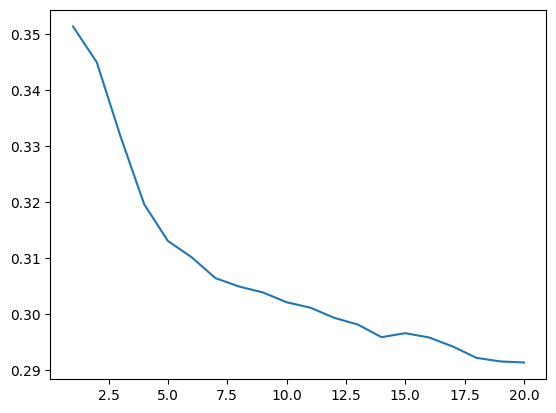

In [ ]:
# Initialize the model
model_ffnn = FeedforwardNeuralNetModel( hidden_dim, output_dim, weights_matrix)
optimizer = torch.optim.SGD(model_ffnn.parameters(), lr=learning_rate)
model_ffnn = model_ffnn.to(device)
# Train the model
training( model_ffnn, train_loader, optimizer, num_epochs=num_epochs, plot=True )
# Evaluate on dev
gold, pred = evaluate( model_ffnn, dev_loader )

In [ ]:
# epochs, hidden, lr, batch, act, opt
exp = Expe( num_epochs, hidden_dim, learning_rate, batch_size, 'sigmoid', 'SGD' )
exp.set_model( model_ffnn )
exp.set_scores( gold, pred )
experiments.append( exp )

-----> BATCH SIZE 100

In [ ]:
# To optimize
batch_size = 100

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Epoch: 0. Loss: 0.00705797830679935. ACC 0.5060672369206286 
Epoch: 1. Loss: 0.007030139309477327. ACC 0.5120350109409191 
Epoch: 2. Loss: 0.0070370292720487344. ACC 0.4995026854983091 
Epoch: 3. Loss: 0.007033164811366734. ACC 0.5008951661030435 
Epoch: 4. Loss: 0.007034888864156382. ACC 0.502287646707778 
Epoch: 5. Loss: 0.007034632921076589. ACC 0.5026854983091307 
Epoch: 6. Loss: 0.007030553423625611. ACC 0.5050726079172468 
Epoch: 7. Loss: 0.007032911381950098. ACC 0.5078575691267158 
Epoch: 8. Loss: 0.007032738128902662. ACC 0.5066640143226576 
Epoch: 9. Loss: 0.007032250644246745. ACC 0.5070618659240104 
Epoch: 10. Loss: 0.007032540581063672. ACC 0.4993037596976328 
Epoch: 11. Loss: 0.007032272223807813. ACC 0.5090511239307738 
Epoch: 12. Loss: 0.0070344977286835655. ACC 0.4985080564949274 
Epoch: 13. Loss: 0.007030598432424411. ACC 0.5050726079172468 
Epoch: 14. Loss: 0.007029776559427147. ACC 0.5058683111199522 
Epoch: 15. Loss: 0.007029959961982425. ACC 0.5088521981300975 
Ep

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


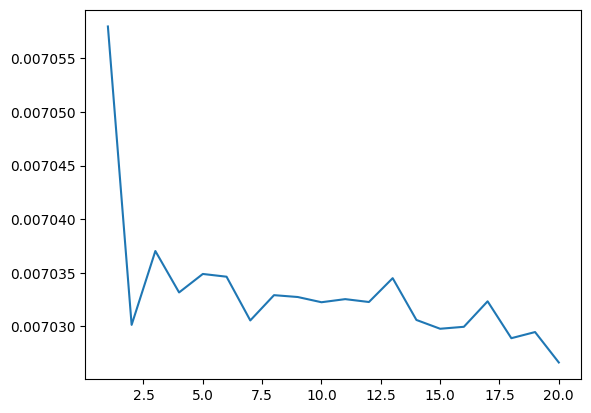

In [ ]:
# Initialize the model
model_ffnn = FeedforwardNeuralNetModel( hidden_dim, output_dim, weights_matrix)
optimizer = torch.optim.SGD(model_ffnn.parameters(), lr=learning_rate)
model_ffnn = model_ffnn.to(device)
# Train the model
training( model_ffnn, train_loader, optimizer, num_epochs=num_epochs, plot=True )
# Evaluate on dev
gold, pred = evaluate( model_ffnn, dev_loader )

In [ ]:
# epochs, hidden, lr, batch, act, opt
exp = Expe( num_epochs, hidden_dim, learning_rate, batch_size, 'sigmoid', 'SGD' )
exp.set_model( model_ffnn )
exp.set_scores( gold, pred )
experiments.append( exp )

-----> BATCH SIZE 10

In [ ]:
# To optimize
batch_size = 10

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn) #<-- use shuffle = True instead
dev_loader = DataLoader(dev, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
# Initialize the model
model_ffnn = FeedforwardNeuralNetModel( hidden_dim, output_dim, weights_matrix)
optimizer = torch.optim.SGD(model_ffnn.parameters(), lr=learning_rate)
model_ffnn = model_ffnn.to(device)
# Train the model
training( model_ffnn, train_loader, optimizer, num_epochs=num_epochs )
# Evaluate on dev
gold, pred = evaluate( model_ffnn, dev_loader )

Epoch: 0. Loss: 0.06960286194414511. ACC 0.5088521981300975 
Epoch: 1. Loss: 0.06949205969587956. ACC 0.5018897951064253 
Epoch: 2. Loss: 0.06919643985411744. ACC 0.5269544459916451 
Epoch: 3. Loss: 0.06909697062219378. ACC 0.5329222200119356 
Epoch: 4. Loss: 0.06878613686974204. ACC 0.5410781778396658 
Epoch: 5. Loss: 0.06825835482605129. ACC 0.5615675353093296 
Epoch: 6. Loss: 0.06760561589528818. ACC 0.5947881440222796 
Epoch: 7. Loss: 0.06679691170659624. ACC 0.6051322856574498 
Epoch: 8. Loss: 0.06587741506343953. ACC 0.6317883429480804 
Epoch: 9. Loss: 0.06498667840244331. ACC 0.6274119753332007 
Epoch: 10. Loss: 0.06396877246323224. ACC 0.6481002586035409 
Epoch: 11. Loss: 0.06312658314513288. ACC 0.649293813407599 
Epoch: 12. Loss: 0.062206074052998106. ACC 0.6626218420529143 
Epoch: 13. Loss: 0.061668635197228365. ACC 0.6707777998806446 
Epoch: 14. Loss: 0.061332281461785515. ACC 0.67157350308335 
Epoch: 15. Loss: 0.06072062264030393. ACC 0.6739606126914661 
Epoch: 16. Loss: 0

In [ ]:
# epochs, hidden, lr, batch, act, opt
exp = Expe( num_epochs, hidden_dim, learning_rate, batch_size, 'sigmoid', 'SGD' )
exp.set_model( model_ffnn )
exp.set_scores( gold, pred )
experiments.append( exp )

------> Perte par rapport à 2, mais beaucoup plus rapide. On garde celui là (we could have tried a few more values here)

In [ ]:
# So now we keep the data loaded with 10 batches
batch_size = 10

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, collate_fn=collate_fn) #<-- use shuffle = True instead
dev_loader = DataLoader(dev, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

### 5.2- Number of epochs

Simply train your model for a large number of epochs.

In [ ]:
num_epochs = 100

Epoch: 0. Loss: 0.06963509724347426. ACC 0.5056693853192759 
Epoch: 1. Loss: 0.0695286692433787. ACC 0.5084543465287448 
Epoch: 2. Loss: 0.06942234052112095. ACC 0.5158146011537696 
Epoch: 3. Loss: 0.06926284745551968. ACC 0.5223791525760891 
Epoch: 4. Loss: 0.06901932719547278. ACC 0.5307340362044958 
Epoch: 5. Loss: 0.06865637074034756. ACC 0.5522180226775413 
Epoch: 6. Loss: 0.06814203977063135. ACC 0.5731052317485578 
Epoch: 7. Loss: 0.06746299424037702. ACC 0.5961806246270142 
Epoch: 8. Loss: 0.06663953955614095. ACC 0.6120946886811219 
Epoch: 9. Loss: 0.06572513203747068. ACC 0.6276109011338771 
Epoch: 10. Loss: 0.06478647729713542. ACC 0.6397453749751343 
Epoch: 11. Loss: 0.06388262006737068. ACC 0.6465088521981301 
Epoch: 12. Loss: 0.0630569500040529. ACC 0.6558583648299184 
Epoch: 13. Loss: 0.06233660556318178. ACC 0.6642132484583251 
Epoch: 14. Loss: 0.06173250857560564. ACC 0.667594987069823 
Epoch: 15. Loss: 0.06124116930616336. ACC 0.6691863934752338 
Epoch: 16. Loss: 0.06

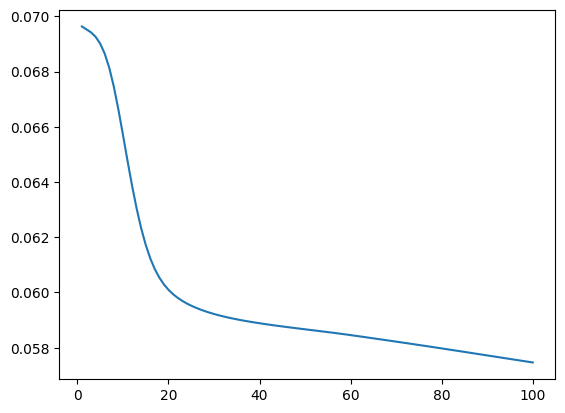

In [ ]:
# Initialize the model
model_ffnn = FeedforwardNeuralNetModel( hidden_dim, output_dim, weights_matrix)
optimizer = torch.optim.SGD(model_ffnn.parameters(), lr=learning_rate)
model_ffnn = model_ffnn.to(device)
# Train the model
training( model_ffnn, train_loader, optimizer, num_epochs=num_epochs, plot=True )
# Evaluate on dev
gold, pred = evaluate( model_ffnn, dev_loader )

---> Loss continues to decrease slightly, but less quickly after 40.

Now we fix the number of epochs to 40.

### 5.3- Hidden Size

In [ ]:
# Hyper-parameters
num_epochs = 40
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()
output_dim = 2

-----> BHIDDEN DIM 10

In [ ]:
# To optimize
hidden_dim = 10

Epoch: 0. Loss: 0.06996377758935216. ACC 0.49830913069425103 
Epoch: 1. Loss: 0.06981138791055264. ACC 0.5016908693057489 
Epoch: 2. Loss: 0.06977116996402032. ACC 0.5024865725084543 
Epoch: 3. Loss: 0.06970947674972673. ACC 0.5056693853192759 
Epoch: 4. Loss: 0.06960997699813812. ACC 0.5104436045355083 
Epoch: 5. Loss: 0.06944751888898915. ACC 0.5182017107618858 
Epoch: 6. Loss: 0.06918649299258096. ACC 0.5265565943902925 
Epoch: 7. Loss: 0.06878434632344774. ACC 0.539486771434255 
Epoch: 8. Loss: 0.06820530898058322. ACC 0.5621643127113587 
Epoch: 9. Loss: 0.06744299065125305. ACC 0.5872289635965785 
Epoch: 10. Loss: 0.06653527622315858. ACC 0.6085140242689476 
Epoch: 11. Loss: 0.06555292989094547. ACC 0.6236323851203501 
Epoch: 12. Loss: 0.06457137288453448. ACC 0.6353690073602546 
Epoch: 13. Loss: 0.06365227370250763. ACC 0.6423314103839268 
Epoch: 14. Loss: 0.06283881240036181. ACC 0.6526755520190969 
Epoch: 15. Loss: 0.06215370156097678. ACC 0.6592401034414164 
Epoch: 16. Loss: 0

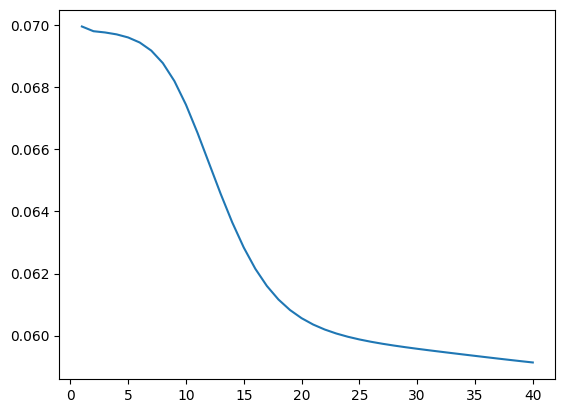

In [ ]:
# Initialize the model
model_ffnn = FeedforwardNeuralNetModel( hidden_dim, output_dim, weights_matrix)
optimizer = torch.optim.SGD(model_ffnn.parameters(), lr=learning_rate)
model_ffnn = model_ffnn.to(device)
# Train the model
training( model_ffnn, train_loader, optimizer, num_epochs=num_epochs, plot=True )
# Evaluate on dev
gold, pred = evaluate( model_ffnn, dev_loader )

In [ ]:
# epochs, hidden, lr, batch, act, opt
exp = Expe( num_epochs, hidden_dim, learning_rate, batch_size, 'sigmoid', 'SGD' )
exp.set_model( model_ffnn )
exp.set_scores( gold, pred )
experiments.append( exp )

-----> HIDDEN DIM 64

In [ ]:
# To optimize
hidden_dim = 64

Epoch: 0. Loss: 0.07275916600715861. ACC 0.5102446787348319 
Epoch: 1. Loss: 0.07249512868893178. ACC 0.5130296399443007 
Epoch: 2. Loss: 0.07222251622819606. ACC 0.5168092301571514 
Epoch: 3. Loss: 0.07190552247146832. ACC 0.5215834493733837 
Epoch: 4. Loss: 0.07150292000524894. ACC 0.5273522975929978 
Epoch: 5. Loss: 0.0709696923415372. ACC 0.5317286652078774 
Epoch: 6. Loss: 0.07027140550829673. ACC 0.5416749552416948 
Epoch: 7. Loss: 0.06940647640758513. ACC 0.553212651680923 
Epoch: 8. Loss: 0.06841664225224688. ACC 0.570917047941118 
Epoch: 9. Loss: 0.06737008235529021. ACC 0.5860354087925204 
Epoch: 10. Loss: 0.0663343019233633. ACC 0.5967774020290432 
Epoch: 11. Loss: 0.06536385625073182. ACC 0.6101054306743585 
Epoch: 12. Loss: 0.06449928389454969. ACC 0.6222399045156157 
Epoch: 13. Loss: 0.06376417517448624. ACC 0.6331808235528148 
Epoch: 14. Loss: 0.0631621678769055. ACC 0.6379550427690471 
Epoch: 15. Loss: 0.06268051691740152. ACC 0.644121742590014 
Epoch: 16. Loss: 0.06229

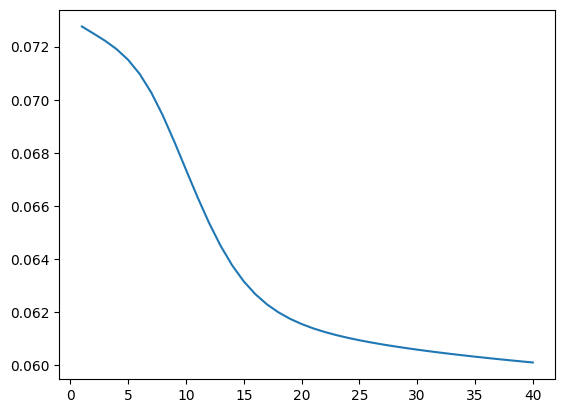

In [ ]:
# Initialize the model
model_ffnn = FeedforwardNeuralNetModel( hidden_dim, output_dim, weights_matrix)
optimizer = torch.optim.SGD(model_ffnn.parameters(), lr=learning_rate)
model_ffnn = model_ffnn.to(device)
# Train the model
training( model_ffnn, train_loader, optimizer, num_epochs=num_epochs, plot=True )
# Evaluate on dev
gold, pred = evaluate( model_ffnn, dev_loader )

In [ ]:
# epochs, hidden, lr, batch, act, opt
exp = Expe( num_epochs, hidden_dim, learning_rate, batch_size, 'sigmoid', 'SGD' )
exp.set_model( model_ffnn )
exp.set_scores( gold, pred )
experiments.append( exp )

-----> HIDDEN DIM 512

In [ ]:
# To optimize
hidden_dim = 512

Epoch: 0. Loss: 0.2978592665040851. ACC 0.4873682116570519 
Epoch: 1. Loss: 0.2278574062124123. ACC 0.4973145016908693 
Epoch: 2. Loss: 0.1829171202482512. ACC 0.4973145016908693 
Epoch: 3. Loss: 0.15505569087171356. ACC 0.4985080564949274 
Epoch: 4. Loss: 0.13253630096285865. ACC 0.5048736821165705 
Epoch: 5. Loss: 0.11563538200152852. ACC 0.5132285657449771 
Epoch: 6. Loss: 0.10475731679737295. ACC 0.5185995623632386 
Epoch: 7. Loss: 0.09711393686087393. ACC 0.5215834493733837 
Epoch: 8. Loss: 0.09105930351252961. ACC 0.5335189974139646 
Epoch: 9. Loss: 0.08641801475411455. ACC 0.5464491744579272 
Epoch: 10. Loss: 0.08267590181239917. ACC 0.5528148000795703 
Epoch: 11. Loss: 0.07960491427517753. ACC 0.5653471255221802 
Epoch: 12. Loss: 0.07709535509970403. ACC 0.5754923413566739 
Epoch: 13. Loss: 0.07504374389978534. ACC 0.5830515217823752 
Epoch: 14. Loss: 0.07336382725875752. ACC 0.595583847224985 
Epoch: 15. Loss: 0.07198763575448605. ACC 0.6037398050527153 
Epoch: 16. Loss: 0.070

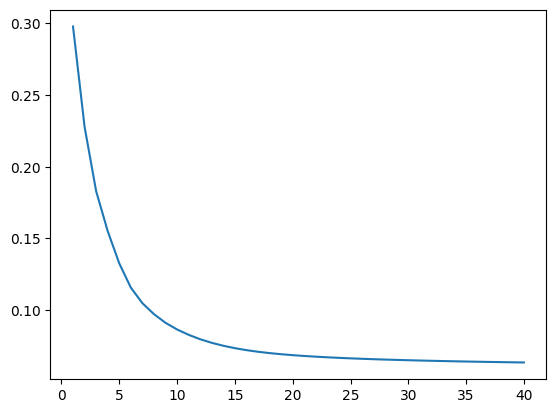

In [ ]:
# Initialize the model
model_ffnn = FeedforwardNeuralNetModel( hidden_dim, output_dim, weights_matrix)
optimizer = torch.optim.SGD(model_ffnn.parameters(), lr=learning_rate)
model_ffnn = model_ffnn.to(device)
# Train the model
training( model_ffnn, train_loader, optimizer, num_epochs=num_epochs, plot=True )
# Evaluate on dev
gold, pred = evaluate( model_ffnn, dev_loader )

In [ ]:
# epochs, hidden, lr, batch, act, opt
exp = Expe( num_epochs, hidden_dim, learning_rate, batch_size, 'sigmoid', 'SGD' )
exp.set_model( model_ffnn )
exp.set_scores( gold, pred )
experiments.append( exp )

### 5.4- Activation Function

In [ ]:
# Already optimized
batch_size = 10
hidden_dim = 10

In [ ]:
# Hyper-parameters
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()
output_dim = 2

------> RELU

----------------------------
SOLUTION

In [ ]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, hidden_dim, output_dim, weights_matrix):
        # calls the init function of nn.Module.  Dont get confused by syntax,
        # just always do it in an nn.Module
        super(FeedforwardNeuralNetModel, self).__init__()

        # Embedding layer
        self.embedding_bag = nn.EmbeddingBag.from_pretrained(
                              weights_matrix,
                              mode='mean')
        embed_dim = self.embedding_bag.embedding_dim

        # Linear function
        self.fc1 = nn.Linear(embed_dim, hidden_dim)

        # Non-linearity
        self.activation = nn.ReLU()

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, offsets):
        # Embedding layer
        embedded = self.embedding_bag(text, offsets)

        # Linear function
        out = self.fc1(embedded)

        # Non-linearity
        out = self.activation(out)

        # Linear function (readout)
        out = self.fc2(out)
        return out

Epoch: 0. Loss: 0.06947135333633575. ACC 0.5044758305152178 
Epoch: 1. Loss: 0.0689417885126213. ACC 0.5388899940322259 
Epoch: 2. Loss: 0.06711450736708116. ACC 0.5933956634175452 
Epoch: 3. Loss: 0.06442576222920575. ACC 0.6307937139446986 
Epoch: 4. Loss: 0.0625185880410593. ACC 0.6512830714143625 
Epoch: 5. Loss: 0.06135143008529962. ACC 0.6628207678535906 
Epoch: 6. Loss: 0.06054908076313444. ACC 0.6685896160732047 
Epoch: 7. Loss: 0.05986351958676648. ACC 0.6753530932962005 
Epoch: 8. Loss: 0.05932085048566643. ACC 0.6795305351104038 
Epoch: 9. Loss: 0.05881184618160505. ACC 0.6801273125124329 
Epoch: 10. Loss: 0.058372599083314436. ACC 0.6851004575293416 
Epoch: 11. Loss: 0.05797103613537966. ACC 0.6882832703401631 
Epoch: 12. Loss: 0.05747430726384842. ACC 0.6898746767455739 
Epoch: 13. Loss: 0.05705877671973094. ACC 0.6906703799482793 
Epoch: 14. Loss: 0.05659139006055324. ACC 0.6948478217624826 
Epoch: 15. Loss: 0.05615444571781709. ACC 0.7006166699820967 
Epoch: 16. Loss: 0.

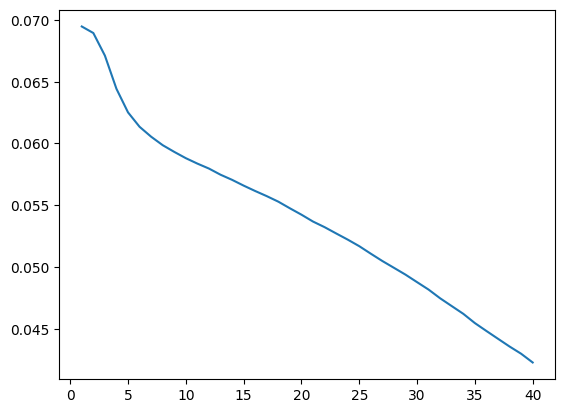

In [ ]:
# Initialize the model
model_ffnn = FeedforwardNeuralNetModel( hidden_dim, output_dim, weights_matrix)
optimizer = torch.optim.SGD(model_ffnn.parameters(), lr=learning_rate)
model_ffnn = model_ffnn.to(device)
# Train the model
training( model_ffnn, train_loader, optimizer, num_epochs=num_epochs, plot=True )
# Evaluate on dev
gold, pred = evaluate( model_ffnn, dev_loader )

In [ ]:
# epochs, hidden, lr, batch, act, opt
exp = Expe( num_epochs, hidden_dim, learning_rate, batch_size, 'relu', 'SGD' )
exp.set_model( model_ffnn )
exp.set_scores( gold, pred )
experiments.append( exp )

------> Hardtanh

In [ ]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, hidden_dim, output_dim, weights_matrix):
        # calls the init function of nn.Module.  Dont get confused by syntax,
        # just always do it in an nn.Module
        super(FeedforwardNeuralNetModel, self).__init__()

        # Embedding layer
        self.embedding_bag = nn.EmbeddingBag.from_pretrained(
                              weights_matrix,
                              mode='mean')
        embed_dim = self.embedding_bag.embedding_dim

        # Linear function
        self.fc1 = nn.Linear(embed_dim, hidden_dim)

        # Non-linearity
        self.activation = nn.Hardtanh()

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, offsets):
        # Embedding layer
        embedded = self.embedding_bag(text, offsets)

        # Linear function
        out = self.fc1(embedded)

        # Non-linearity
        out = self.activation(out)

        # Linear function (readout)
        out = self.fc2(out)
        return out

Epoch: 0. Loss: 0.06924010234915857. ACC 0.5174060075591804 
Epoch: 1. Loss: 0.0676556401397875. ACC 0.5802665605729063 
Epoch: 2. Loss: 0.06508188367316801. ACC 0.6305947881440223 
Epoch: 3. Loss: 0.06323095920760802. ACC 0.644121742590014 
Epoch: 4. Loss: 0.06223800997148813. ACC 0.6568529938333002 
Epoch: 5. Loss: 0.06170375551194729. ACC 0.6618261388502089 
Epoch: 6. Loss: 0.061271748000688096. ACC 0.6640143226576487 
Epoch: 7. Loss: 0.061038093435757196. ACC 0.6660035806644121 
Epoch: 8. Loss: 0.06074255015400928. ACC 0.668191764471852 
Epoch: 9. Loss: 0.06063684351002693. ACC 0.6695842450765864 
Epoch: 10. Loss: 0.06040970502991503. ACC 0.6709767256813208 
Epoch: 11. Loss: 0.060354981527713604. ACC 0.6713745772826736 
Epoch: 12. Loss: 0.06018284043830362. ACC 0.673363835289437 
Epoch: 13. Loss: 0.06014509342858349. ACC 0.6743584642928188 
Epoch: 14. Loss: 0.06001727005253024. ACC 0.6767455739009349 
Epoch: 15. Loss: 0.05998357945487351. ACC 0.6761487964989059 
Epoch: 16. Loss: 0.

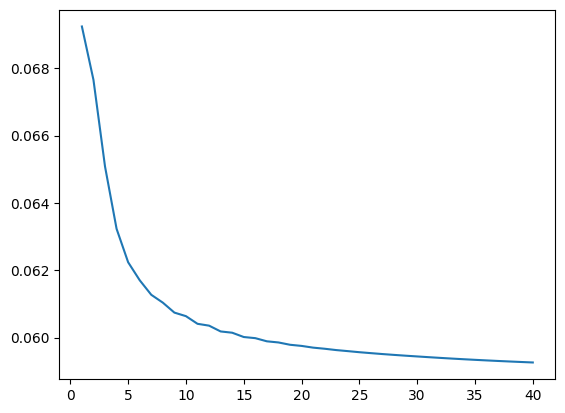

In [ ]:
# Initialize the model
model_ffnn = FeedforwardNeuralNetModel( hidden_dim, output_dim, weights_matrix)
optimizer = torch.optim.SGD(model_ffnn.parameters(), lr=learning_rate)
model_ffnn = model_ffnn.to(device)
# Train the model
training( model_ffnn, train_loader, optimizer, num_epochs=num_epochs, plot=True )
# Evaluate on dev
gold, pred = evaluate( model_ffnn, dev_loader )

In [ ]:
# epochs, hidden, lr, batch, act, opt
exp = Expe( num_epochs, hidden_dim, learning_rate, batch_size, 'hardthan', 'SGD' )
exp.set_model( model_ffnn )
exp.set_scores( gold, pred )
experiments.append( exp )

### 5.5- Learning Rate

In [ ]:
# Already optimized
batch_size = 10
hidden_dim = 10

----> learning_rate = 0.0001

In [ ]:
# To optimize
learning_rate = 0.0001

Epoch: 0. Loss: 0.07342526102032841. ACC 0.5086532723294211 
Epoch: 1. Loss: 0.07310842124918286. ACC 0.5086532723294211 
Epoch: 2. Loss: 0.0728152275725722. ACC 0.5086532723294211 
Epoch: 3. Loss: 0.07254399489948568. ACC 0.5086532723294211 
Epoch: 4. Loss: 0.07229314763147124. ACC 0.5086532723294211 
Epoch: 5. Loss: 0.07206122276914365. ACC 0.5086532723294211 
Epoch: 6. Loss: 0.07184685393500949. ACC 0.5086532723294211 
Epoch: 7. Loss: 0.07164877362627857. ACC 0.5086532723294211 
Epoch: 8. Loss: 0.07146579816845555. ACC 0.5086532723294211 
Epoch: 9. Loss: 0.07129681940365198. ACC 0.5086532723294211 
Epoch: 10. Loss: 0.07114081563450647. ACC 0.5086532723294211 
Epoch: 11. Loss: 0.07099682093852316. ACC 0.5086532723294211 
Epoch: 12. Loss: 0.07086395204766788. ACC 0.5084543465287448 
Epoch: 13. Loss: 0.07074137500676052. ACC 0.5084543465287448 
Epoch: 14. Loss: 0.07062831854806023. ACC 0.5084543465287448 
Epoch: 15. Loss: 0.07052406504444937. ACC 0.5084543465287448 
Epoch: 16. Loss: 0.

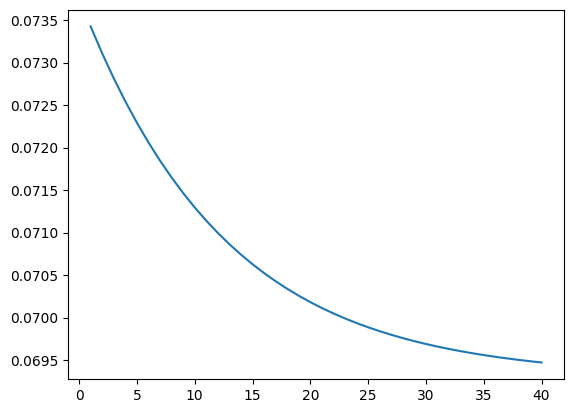

In [ ]:
# Initialize the model
model_ffnn = FeedforwardNeuralNetModel( hidden_dim, output_dim, weights_matrix)
optimizer = torch.optim.SGD(model_ffnn.parameters(), lr=learning_rate)
model_ffnn = model_ffnn.to(device)
# Train the model
training( model_ffnn, train_loader, optimizer, num_epochs=num_epochs, plot=True )
# Evaluate on dev
gold, pred = evaluate( model_ffnn, dev_loader )

In [ ]:
# epochs, hidden, lr, batch, act, opt
exp = Expe( num_epochs, hidden_dim, learning_rate, batch_size, 'hardthan', 'SGD' )
exp.set_model( model_ffnn )
exp.set_scores( gold, pred )
experiments.append( exp )

----> learning_rate = 0.1

In [ ]:
# To optimize
learning_rate = 0.1

Epoch: 0. Loss: 0.06908447540420554. ACC 0.5317286652078774 
Epoch: 1. Loss: 0.06696160580212206. ACC 0.5999602148398647 
Epoch: 2. Loss: 0.06447852052702258. ACC 0.6333797493534912 
Epoch: 3. Loss: 0.06289903144606876. ACC 0.6455142231947484 
Epoch: 4. Loss: 0.06208572018708532. ACC 0.6586433260393874 
Epoch: 5. Loss: 0.0615576500562543. ACC 0.6608315098468271 
Epoch: 6. Loss: 0.06123311275489197. ACC 0.6642132484583251 
Epoch: 7. Loss: 0.0609200120458362. ACC 0.6666003580664412 
Epoch: 8. Loss: 0.06075057267597283. ACC 0.6677939128704993 
Epoch: 9. Loss: 0.06053232903008151. ACC 0.6711756514819972 
Epoch: 10. Loss: 0.06042892793098975. ACC 0.6705788740799682 
Epoch: 11. Loss: 0.06027004342679596. ACC 0.6723692062860553 
Epoch: 12. Loss: 0.06020159977009312. ACC 0.672170280485379 
Epoch: 13. Loss: 0.06008046564297954. ACC 0.6745573900934951 
Epoch: 14. Loss: 0.06003037668351082. ACC 0.6749552416948478 
Epoch: 15. Loss: 0.059936986574008304. ACC 0.6765466481002586 
Epoch: 16. Loss: 0.0

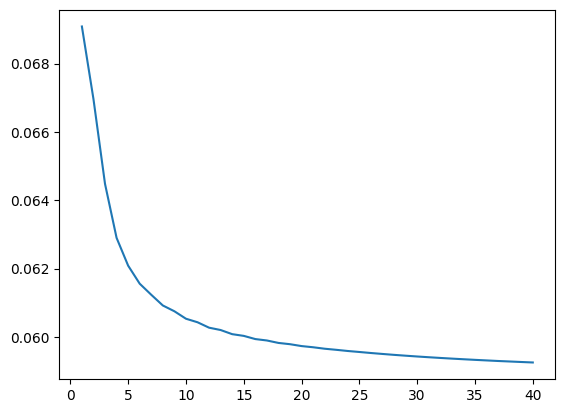

In [ ]:
# Initialize the model
model_ffnn = FeedforwardNeuralNetModel( hidden_dim, output_dim, weights_matrix)
optimizer = torch.optim.SGD(model_ffnn.parameters(), lr=learning_rate)
model_ffnn = model_ffnn.to(device)
# Train the model
training( model_ffnn, train_loader, optimizer, num_epochs=num_epochs, plot=True )
# Evaluate on dev
gold, pred = evaluate( model_ffnn, dev_loader )

In [ ]:
# epochs, hidden, lr, batch, act, opt
exp = Expe( num_epochs, hidden_dim, learning_rate, batch_size, 'hardthan', 'SGD' )
exp.set_model( model_ffnn )
exp.set_scores( gold, pred )
experiments.append( exp )

----> learning_rate = 0.5

In [ ]:
# To optimize
learning_rate = 0.5

Epoch: 0. Loss: 0.06924024741242224. ACC 0.5374975134274915 
Epoch: 1. Loss: 0.06607861800579848. ACC 0.6015516212452755 
Epoch: 2. Loss: 0.06393702824120022. ACC 0.6299980107419932 
Epoch: 3. Loss: 0.0628489178894575. ACC 0.640740003978516 
Epoch: 4. Loss: 0.06203776908034664. ACC 0.6524766262184205 
Epoch: 5. Loss: 0.061449412870814984. ACC 0.659637955042769 
Epoch: 6. Loss: 0.060906915795573044. ACC 0.6648100258603541 
Epoch: 7. Loss: 0.060446302696798675. ACC 0.66938531927591 
Epoch: 8. Loss: 0.05996372725467025. ACC 0.67157350308335 
Epoch: 9. Loss: 0.05948941482804228. ACC 0.6741595384921424 
Epoch: 10. Loss: 0.05903786109282052. ACC 0.6803262383131092 
Epoch: 11. Loss: 0.05859775083580097. ACC 0.683111199522578 
Epoch: 12. Loss: 0.05821072372309797. ACC 0.6874875671374577 
Epoch: 13. Loss: 0.05781896588744002. ACC 0.6892778993435449 
Epoch: 14. Loss: 0.05745339588365333. ACC 0.6940521185597772 
Epoch: 15. Loss: 0.05710244000622025. ACC 0.6978317087726278 
Epoch: 16. Loss: 0.0567

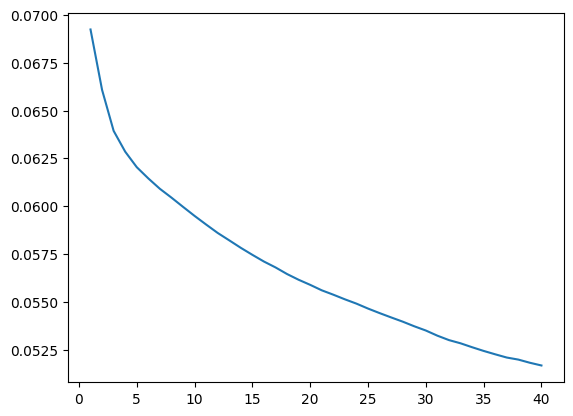

In [ ]:
# Initialize the model
model_ffnn = FeedforwardNeuralNetModel( hidden_dim, output_dim, weights_matrix)
optimizer = torch.optim.SGD(model_ffnn.parameters(), lr=learning_rate)
model_ffnn = model_ffnn.to(device)
# Train the model
training( model_ffnn, train_loader, optimizer, num_epochs=num_epochs, plot=True )
# Evaluate on dev
gold, pred = evaluate( model_ffnn, dev_loader )

----> learning_rate = 10

In [ ]:
# To optimize
learning_rate = 10

Epoch: 0. Loss: 3.0166748961682393. ACC 0.4981102048935747 
Epoch: 1. Loss: 3.0057952245732578. ACC 0.4973145016908693 
Epoch: 2. Loss: 3.012421615026048. ACC 0.4993037596976328 
Epoch: 3. Loss: 3.1523107549222678. ACC 0.4859757310523175 
Epoch: 4. Loss: 2.944609932173121. ACC 0.5042769047145415 
Epoch: 5. Loss: 3.005021988574852. ACC 0.5008951661030435 
Epoch: 6. Loss: 2.9698043898035524. ACC 0.4989059080962801 
Epoch: 7. Loss: 3.025354045118469. ACC 0.4941316888800477 
Epoch: 8. Loss: 2.87215760845253. ACC 0.5058683111199522 
Epoch: 9. Loss: 2.876202580099768. ACC 0.507459717525363 
Epoch: 10. Loss: 2.969862364900973. ACC 0.5000994629003381 
Epoch: 11. Loss: 3.0069589921131934. ACC 0.49830913069425103 
Epoch: 12. Loss: 2.909736330463655. ACC 0.5064650885219814 
Epoch: 13. Loss: 2.9427568858082926. ACC 0.5002983887010145 
Epoch: 14. Loss: 3.0380569062556426. ACC 0.4941316888800477 
Epoch: 15. Loss: 2.9768166160616696. ACC 0.49711557589019295 
Epoch: 16. Loss: 2.845160269976753. ACC 0.

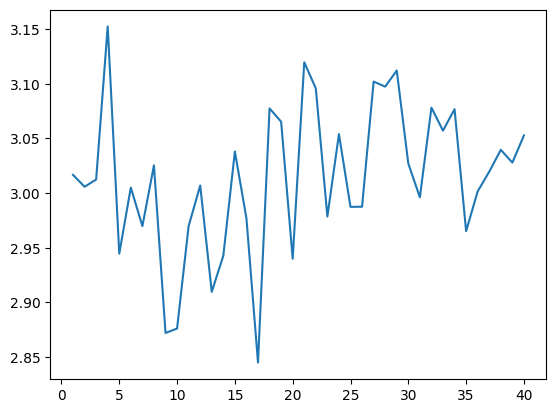

In [ ]:
# Initialize the model
model_ffnn = FeedforwardNeuralNetModel( hidden_dim, output_dim, weights_matrix)
optimizer = torch.optim.SGD(model_ffnn.parameters(), lr=learning_rate)
model_ffnn = model_ffnn.to(device)
# Train the model
training( model_ffnn, train_loader, optimizer, num_epochs=num_epochs, plot=True )
# Evaluate on dev
gold, pred = evaluate( model_ffnn, dev_loader )

### 5.6- Optimizer

In [ ]:
for expe in experiments:
  print(expe.to_string())

40 10 0.1 10 hardthan SGD


In [ ]:
# Already optimized
num_epochs = 40
batch_size = 10
hidden_dim = 10
learning_rate = 0.1
# activation = hard than


-------> Adam

Epoch: 0. Loss: 0.07316462491363471. ACC 0.55719116769445 
Epoch: 1. Loss: 0.06831659184835862. ACC 0.6194549433061468 
Epoch: 2. Loss: 0.06881633621455424. ACC 0.6220409787149394 
Epoch: 3. Loss: 0.06739485650359457. ACC 0.6395464491744579 
Epoch: 4. Loss: 0.06657098044285795. ACC 0.6471056296001592 
Epoch: 5. Loss: 0.06574313069269674. ACC 0.658444400238711 
Epoch: 6. Loss: 0.06506116019818663. ACC 0.6558583648299184 
Epoch: 7. Loss: 0.06504748362076314. ACC 0.6608315098468271 
Epoch: 8. Loss: 0.06595309020149938. ACC 0.6646111000596777 
Epoch: 9. Loss: 0.06670350689157141. ACC 0.6526755520190969 
Epoch: 10. Loss: 0.06476127602469739. ACC 0.6775412771036403 
Epoch: 11. Loss: 0.06408558086654598. ACC 0.6707777998806446 
Epoch: 12. Loss: 0.06455305347047555. ACC 0.6662025064650885 
Epoch: 13. Loss: 0.06423317511927804. ACC 0.6795305351104038 
Epoch: 14. Loss: 0.06340794157372427. ACC 0.6837079769246072 
Epoch: 15. Loss: 0.06377620607027601. ACC 0.6851004575293416 
Epoch: 16. Loss: 0.06

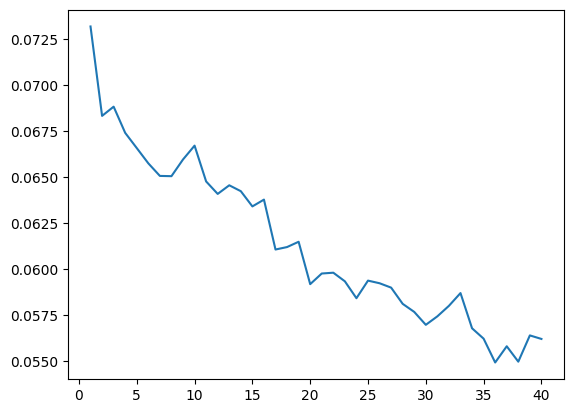

In [ ]:
# Initialize the model
model_ffnn = FeedforwardNeuralNetModel( hidden_dim, output_dim, weights_matrix)

# --> Adam
optimizer = torch.optim.Adam(model_ffnn.parameters(), lr=learning_rate)

model_ffnn = model_ffnn.to(device)
# Train the model
training( model_ffnn, train_loader, optimizer, num_epochs=num_epochs, plot=True )
# Evaluate on dev
gold, pred = evaluate( model_ffnn, dev_loader )

------> RMSProp

Epoch: 0. Loss: 0.09518847184269429. ACC 0.5261587427889397 
Epoch: 1. Loss: 0.08241781907466242. ACC 0.5653471255221802 
Epoch: 2. Loss: 0.07882078389465062. ACC 0.5770837477620847 
Epoch: 3. Loss: 0.07559202145173721. ACC 0.5973741794310722 
Epoch: 4. Loss: 0.07301282952942573. ACC 0.6170678336980306 
Epoch: 5. Loss: 0.0723440936404003. ACC 0.6266162721304953 
Epoch: 6. Loss: 0.07065994856145098. ACC 0.6391485975731053 
Epoch: 7. Loss: 0.07046600024215692. ACC 0.6477024070021882 
Epoch: 8. Loss: 0.06900936739805656. ACC 0.645912074796101 
Epoch: 9. Loss: 0.06822866038961203. ACC 0.6642132484583251 
Epoch: 10. Loss: 0.06619252894101144. ACC 0.6713745772826736 
Epoch: 11. Loss: 0.06547287488158. ACC 0.6799283867117565 
Epoch: 12. Loss: 0.06568151244959254. ACC 0.6749552416948478 
Epoch: 13. Loss: 0.06457823484406833. ACC 0.6866918639347523 
Epoch: 14. Loss: 0.06335515739229106. ACC 0.6930574895563955 
Epoch: 15. Loss: 0.06263002634392312. ACC 0.6984284861746568 
Epoch: 16. Loss: 0.0611

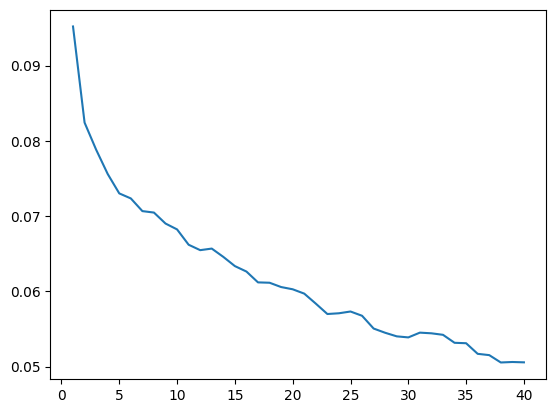

In [ ]:
# Initialize the model
model_ffnn = FeedforwardNeuralNetModel( hidden_dim, output_dim, weights_matrix)

# --> RMSprop
optimizer = torch.optim.RMSprop(model_ffnn.parameters(), lr=learning_rate)

model_ffnn = model_ffnn.to(device)
# Train the model
training( model_ffnn, train_loader, optimizer, num_epochs=num_epochs, plot=True )
# Evaluate on dev
gold, pred = evaluate( model_ffnn, dev_loader )

### 5.7- [Optional] Additional exercise

Modify your model to test a variation on the architecture. Here you don't have to tune all your model again, just try for example when keeping the best values found previously for the hyper-parameters:

* Try with 1 additional hidden layer